In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import random
import tensorflow as tf
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
df = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=['Date'], index_col=0).sort_index()
df['Close'] = df['Close'].str.replace(',', '')
df['Close'] = df['Close'].astype(float)
df.drop(columns=['Volume'], inplace=True)
for idx in df.index:
    if df.loc[idx, 'Close'] > df.loc[idx, 'High']:
        df.loc[idx, 'Close'] = df.loc[idx, 'Close']/2

In [3]:
df.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409,533.712258
std,151.904442,153.008811,150.552807,151.618792
min,279.120000,281.210000,277.220000,278.760000
25%,404.115000,406.765000,401.765000,404.527500
50%,537.470000,540.750000,532.990000,537.532500
75%,654.922500,662.587500,644.800000,652.172500
max,816.680000,816.680000,805.140000,813.110000


In [4]:
px.line(df)

## 1. MANY TO ONE UNIVARIATE - CLOSE

In [5]:
def create_sequences(data, look_back=1): # many to one UNIVARIATE:
    dataX, dataY = [], []
    for i in range(len(data) - look_back-1):
        dataX.append(data[i:(i+look_back), :])
        dataY.append(data[i+look_back, :])
    return np.array(dataX), np.array(dataY)

In [6]:
close_data = df[['Close']].values
idx = int(0.8*close_data.shape[0])
close_train = close_data[:idx]
close_test = close_data[idx:]
print(close_train.shape)
print(close_test.shape)

(1006, 1)
(252, 1)


In [7]:
LOOKBACK = 30
close_trainX, close_trainY = create_sequences(close_train, look_back=LOOKBACK)
close_testX, close_testY = create_sequences(close_test, look_back=LOOKBACK)

In [8]:
print(close_trainX.shape)
print(close_testX.shape)

(975, 30, 1)
(221, 30, 1)


In [9]:
# HOMEWORK 1:
# TRY DIFFERENT ARCHITECTURES
# DROPOUT, BATCHNORM, STACK or remove LSTMs...
# LOOKBACK PERIOD 
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(LOOKBACK, 1),return_sequences=True))
model.add(LSTM(60, activation='relu', input_shape=(LOOKBACK, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 60)                38640     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 79,501
Trainable params: 79,501
Non-trainable params: 0
_________________________________________________________________


In [10]:
es_cbk = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [12]:
model_history = model.fit(
    close_trainX,
    close_trainY,
    epochs=100,
    batch_size=1,
    validation_data = (close_testX, close_testY),
    callbacks = [es_cbk]
)

Epoch 1/100
975/975 [==============================] - 7s 6ms/step - loss: 250.6670 - val_loss: 25.4352
Epoch 2/100
975/975 [==============================] - 6s 6ms/step - loss: 28.1569 - val_loss: 29.8731
Epoch 3/100
975/975 [==============================] - 5s 6ms/step - loss: 29.1059 - val_loss: 24.5058
Epoch 4/100
975/975 [==============================] - 5s 6ms/step - loss: 31.3586 - val_loss: 28.5074
Epoch 5/100
975/975 [==============================] - 5s 6ms/step - loss: 32.2987 - val_loss: 30.5221
Epoch 6/100
975/975 [==============================] - 5s 6ms/step - loss: 31.6393 - val_loss: 42.7923
Epoch 7/100
975/975 [==============================] - 5s 6ms/step - loss: 32.1732 - val_loss: 26.3173
Epoch 8/100
975/975 [==============================] - 5s 6ms/step - loss: 32.0714 - val_loss: 26.6517
Epoch 9/100
975/975 [==============================] - 5s 6ms/step - loss: 32.6302 - val_loss: 59.9399
Epoch 10/100
975/975 [==============================] - 6s 6ms/step - lo

In [17]:
close_train_pred = model.predict(close_trainX)
close_test_pred = model.predict(close_testX)

7/7 [==============================] - 0s 4ms/step


In [22]:
print(close_test_pred.shape)
print(close_testY.shape)

(221, 1)
(221, 1)


In [29]:
print(mean_absolute_error(close_testY[:, 0], close_test_pred[:, 0]))
print(r2_score(close_testY[:, 0], close_test_pred[:,0]))

24.505771882070135
0.1720496152340737


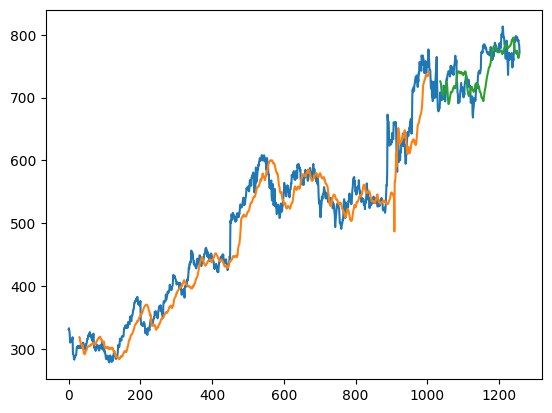

In [31]:
plt.plot(close_data)
train_plot = np.empty_like(close_data)
train_plot[:] = np.nan
train_plot[LOOKBACK:LOOKBACK+len(close_train_pred), :] = close_train_pred

test_plot = np.empty_like(close_data)
test_plot[:] = np.nan
test_plot[len(close_train_pred) + (2*LOOKBACK+1):len(close_data)-1, :] = close_test_pred
plt.plot(train_plot)
plt.plot(test_plot)
